<a href="https://colab.research.google.com/github/narayansharma275/pytorch/blob/main/TransLearningForImgClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading the Dataset

I'll use the Oxford-IIIT Pets dataset from https://course.fast.ai/datasets . It is 37 category (breeds) pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. 

In [1]:
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 71kB 5.4MB/s 


In [2]:
from torchvision.datasets.utils import download_url

In [3]:
download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

In [5]:
import tarfile

with tarfile.open('/content/oxford-iiit-pet.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')

In [6]:
import os

DATA_DIR= '/content/data/oxford-iiit-pet/images'
files = os.listdir(DATA_DIR)
len(files), files[:5]

(7393,
 ['english_setter_88.jpg',
  'samoyed_59.jpg',
  'Russian_Blue_16.jpg',
  'Ragdoll_92.jpg',
  'yorkshire_terrier_55.jpg'])

So we have 7393 images and each image has its class mentioned in its name

In [7]:
#to create class names
def parse_breed(name):
  parts = name.split('_')
  return ' '.join(parts[:-1])


In [8]:
parse_breed(files[0])

'english setter'

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

def open_image(path):
    with open(path,'rb') as f:
      img = Image.open(f)
      return img.convert('RGB')

Creating a Pytorch Dataset

In [10]:
import os
from torch.utils.data import Dataset

class PetsDataset(Dataset):
  def __init__(self, root, transform):
    super().__init__()
    self.root      = root
    self.files     = [file for file in os.listdir(root) if file.endswith('jpg')]
    self.classes   = list(set(parse_breed(fname) for fname in files))
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self,i):
    fname     = self.files[i]
    path      = os.path.join(self.root, fname)
    img       = self.transform(open_image(path))
    class_idx = self.classes.index(parse_breed(fname))
    return img, class_idx    

In [11]:
import torchvision.transforms as T

img_size = 224
imagenet_stats= ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset= PetsDataset(DATA_DIR, T.Compose([T.Resize(img_size),
                                         T.Pad(8, padding_mode='reflect'),
                                         T.RandomCrop(img_size),
                                         T.ToTensor(),
                                         T.Normalize(*imagenet_stats)]))

In [12]:
len(dataset)

7390

In [13]:
import torch
import matplotlib.pyplot as plt

%matplotlib inline

def denormalize(images, means, stds):
  if len(images.shape)==3:
    images= images.unsqueeze(0)
  means = torch.tensor(means).reshape(1,3,1,1)
  stds  = torch.tensor(stds).reshape(1,3,1,1)

  return images * stds + means

def show_image(img_tensor, label):
  print(' Label: ', dataset.classes[label], '('+str(label) +')')
  img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1,2,0))
  plt.xticks([]), plt.yticks([])
  plt.imshow(img_tensor)   

 Label:  yorkshire terrier (8)


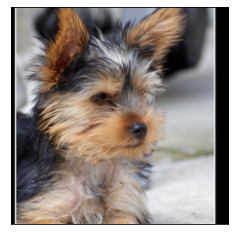

In [14]:
show_image(*dataset[19])

Creating Training and Validation Sets

In [15]:
from torch.utils.data import random_split

In [19]:
val_pct = 0.1
val_size = int(val_pct*len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset)-val_size, val_size])

In [20]:
from torch.utils.data import DataLoader
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [21]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break




/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


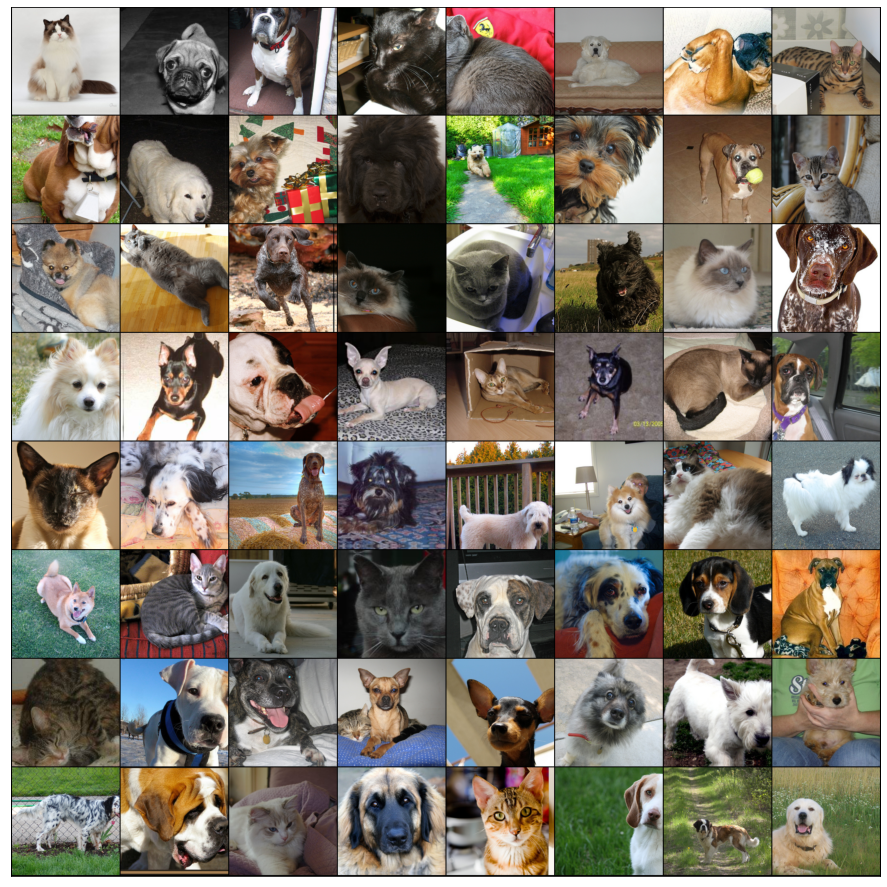

In [22]:
show_batch(train_dl)

> ## Modifying a Pretrained Model (ResNet34)

Transfer learning ([source](https://mc.ai/transfer-learning-with-deep-learning-machine-learning-techniques/)):
![transfer-learning](https://miro.medium.com/max/1000/1*LUFUl_8fqS97nUzpcFjgWw.png)


In [23]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))


In [25]:
from torchvision import models

class PetsModel(ImageClassificationBase):
   def __init__(self,num_classes,pretrained=True):
     super().__init__()
     self.network= models.resnet34(pretrained=pretrained)
     self.network.fc= nn.Linear(self.network.fc.in_features, num_classes)
   def forward(self,xb):
    return self.network(xb)


## GPU Utilities and Training Loop

In [26]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [27]:

from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
device = get_default_device()
device

device(type='cuda')

In [29]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [30]:
model = PetsModel(len(dataset.classes))
to_device(model, device);

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [31]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.01784915290772915, 'val_loss': 3.979592800140381}]

In [35]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [36]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [0],last_lr: 0.00100, train_loss: 0.2613, val_loss: 0.6168, val_acc: 0.8213



Epoch [1],last_lr: 0.00274, train_loss: 0.2402, val_loss: 1.0481, val_acc: 0.7177



Epoch [2],last_lr: 0.00515, train_loss: 0.4361, val_loss: 3.9792, val_acc: 0.3320



Epoch [3],last_lr: 0.00757, train_loss: 0.7829, val_loss: 5.7287, val_acc: 0.2317



Epoch [4],last_lr: 0.00935, train_loss: 0.9290, val_loss: 2.2822, val_acc: 0.4300



Epoch [5],last_lr: 0.01000, train_loss: 0.8515, val_loss: 3.0099, val_acc: 0.3742



Epoch [6],last_lr: 0.00987, train_loss: 0.7602, val_loss: 2.1655, val_acc: 0.4268



Epoch [7],last_lr: 0.00950, train_loss: 0.6919, val_loss: 2.7271, val_acc: 0.3876



Epoch [8],last_lr: 0.00891, train_loss: 0.6002, val_loss: 1.5737, val_acc: 0.5857



Epoch [9],last_lr: 0.00812, train_loss: 0.5470, val_loss: 1.6244, val_acc: 0.5412



Epoch [10],last_lr: 0.00717, train_loss: 0.4426, val_loss: 1.6438, val_acc: 0.5879



Epoch [11],last_lr: 0.00611, train_loss: 0.3466, val_loss: 0.8545, val_acc: 0.7514



Epoch [12],last_lr: 0.00500, train_loss: 0.2416, val_loss: 0.7860, val_acc: 0.7908



Epoch [13],last_lr: 0.00389, train_loss: 0.1820, val_loss: 0.7356, val_acc: 0.7891



Epoch [14],last_lr: 0.00283, train_loss: 0.1273, val_loss: 0.7848, val_acc: 0.7668



Epoch [15],last_lr: 0.00188, train_loss: 0.0993, val_loss: 0.6280, val_acc: 0.8289



Epoch [16],last_lr: 0.00109, train_loss: 0.0654, val_loss: 0.5721, val_acc: 0.8409



Epoch [17],last_lr: 0.00050, train_loss: 0.0440, val_loss: 0.5352, val_acc: 0.8553



Epoch [18],last_lr: 0.00013, train_loss: 0.0335, val_loss: 0.5380, val_acc: 0.8658



Epoch [19],last_lr: 0.00000, train_loss: 0.0298, val_loss: 0.5106, val_acc: 0.8612
CPU times: user 1min 43s, sys: 1min 29s, total: 3min 12s
Wall time: 16min 14s


In [37]:
import jovian
jovian.commit(project='transfer-learning-pytorch')

[jovian] Detected Colab notebook...


[jovian] Error: jovian.commit doesn't work on Colab unless the notebook was created and executed from Jovian.
Make sure to run the first code cell at the top after executing from Jovian.
Alternatively, you can download this notebook and upload it manually to Jovian.
Learn more: https://jovian.ai/docs/user-guide/run.html#run-on-colab
